<a href="https://colab.research.google.com/github/andresvir14/HWDCC_LFTK-/blob/master/HWDCC_LFTK_Final_Proyect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
# Basic libraries
import pandas as pd
import numpy as np

# Preprocesing and feature extraction
from itertools import product
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance

# Ploting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# To deal with downloaded files
from google.colab import files

# Others
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Functions used

# Downcast variables 
def downcast(df):
  '''
    Change columns types from 64 to 32 bits
  '''
  float64columns = df.select_dtypes(['float64']).columns.tolist()
  int64columns = df.select_dtypes(['int64']).columns.tolist()
  df[float64columns] = df[float64columns].astype('float32')
  df[int64columns] = df[int64columns].astype('int32')
  return df

# Averages of target variables
def averagevalues(df, group, target):
  '''
  Takes a group of variables (from one two three) and a target variables to return the average 
  '''
  grouped = df.groupby(group).agg({target: ['mean']})
  
  if (len(group) == 1):
    grouped.columns = [group[0]+'_avg_'+target]
  elif (len(group) == 2):
    grouped.columns = [group[0]+'_'+group[1]+'_avg_'+target]
  else:
    grouped.columns = [group[0]+'_'+group[1]+'-'+group[2]+'_avg_'+target]

  grouped.reset_index(inplace=True)
  df = pd.merge(df, grouped, on=group, how='left')
  return df

# Function to compute the mean encodings for each categorical feature (Via Leave-one-out scheme)
def meaneconloo(df, catfeature):
    '''
    df: Pandas data frame that contains categorical and target features
    catfeature: feature we want to create the mean encoding regularized through LOO scheme
    '''
    target_sum = df.groupby(catfeature)['target'].transform('sum')
    n_objects  = df.groupby(catfeature)['target'].transform('count')
    df[catfeature+'_ME'] = (target_sum - df['target']) / (n_objects - 1)
    df[catfeature+'_ME'].fillna(df[catfeature+'_ME'].mean(), inplace=True)
    return df

# Function that creates the lags of given columns
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+ str(i)]
        shifted['date_block_num'] += i
        shifted[col+'_lag_'+ str(i)] = shifted[col+'_lag_'+ str(i)].astype('float16')
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df    

In [0]:
# Load de the data
transactions    = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/sales_train.csv')
items           = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/item_categories.csv')
shops           = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/shops.csv')
transactions_test    = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/test.csv')


In [0]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions[transactions['date_block_num']==block_num]['shop_id'].unique()
    cur_items = transactions[transactions['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype = 'int16'))

# Turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int32)

# Get aggregated values of sales by shop_id, item_id
gb = transactions.groupby(index_cols).agg({'item_cnt_day':'sum'})
gb.columns = ['target']
gb.reset_index(inplace = True)

# Join aggregated data to the grid and sort the data
train = pd.merge(grid, gb, how='left',on=index_cols).fillna(0)
train['target'] = train['target'].clip(0,20)
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

del grid, gb

In [0]:
# Set ID as index and join train with test data
transactions_test.set_index('ID', inplace = True)
transactions_test['date_block_num'] = 34
data = pd.concat([train, transactions_test], sort = False)
data = downcast(data)

del train

In [0]:
data = pd.merge(data, items, on = ['item_id']) # Join item_name and item category
data = pd.merge(data, shops, on = ['shop_id']) # Join shop_name

del items, shops, item_categories

In [0]:
# Target means by groups
data = averagevalues(data, ['shop_id'], 'target')
data = averagevalues(data, ['item_id'], 'target')
data = averagevalues(data, ['item_category_id'], 'target')
data = averagevalues(data, ['date_block_num'], 'target')

data = averagevalues(data, ['date_block_num', 'item_id'], 'target')
data = averagevalues(data, ['date_block_num', 'shop_id'], 'target')
data = averagevalues(data, ['date_block_num', 'item_category_id'], 'target')

data = averagevalues(data, ['shop_id', 'item_id'], 'target')
data = averagevalues(data, ['shop_id', 'item_category_id'], 'target')

data = downcast(data)

In [0]:
# Mean encodings (LOO) for shop_id and item_id
#data = meaneconloo(data, 'shop_id')
#data = meaneconloo(data, 'item_id')
#data = meaneconloo(data, 'item_category_id')

#data = meaneconloo(data, 'date_block_num')

# Concatenation to have interections of groups
#data['shop_item'] = data['shop_id'].astype(str) + data['item_id'].astype(str)
#data = meaneconloo(data, 'shop_item')

#data['block_shop'] = data['date_block_num'].astype(str) + data['shop_id'].astype(str)
#data = meaneconloo(data, 'block_shop')

#data['block_item'] = data['date_block_num'].astype(str) + data['item_id'].astype(str)
#data = meaneconloo(data, 'block_item')

#data['block_cat'] = data['date_block_num'].astype(str) + data['item_category_id'].astype(str)
#data = meaneconloo(data, 'block_cat')

In [9]:
data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'item_name',
       'item_category_id', 'shop_name', 'shop_id_avg_target',
       'item_id_avg_target', 'item_category_id_avg_target',
       'date_block_num_avg_target', 'date_block_num_item_id_avg_target',
       'date_block_num_shop_id_avg_target',
       'date_block_num_item_category_id_avg_target',
       'shop_id_item_id_avg_target', 'shop_id_item_category_id_avg_target'],
      dtype='object')

In [10]:
# Lagged values
ts = time.time()

data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'shop_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'item_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'item_category_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'date_block_num_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'date_block_num_item_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'date_block_num_shop_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'date_block_num_item_category_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'shop_id_item_id_avg_target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'shop_id_item_category_id_avg_target')

#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'shop_id_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'item_id_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'item_category_id_ME')

#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'date_block_num_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'shop_item_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'block_shop_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'block_item_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'block_cat_ME')

time.time() - ts

597.4114997386932

In [0]:
# Drop some level variables (lag 0)
#data.drop(['shop_id_avg_target', 'item_id_avg_target', 'item_category_id_avg_target', 'date_block_num_avg_target','shop_id_ME', 'item_id_ME', 'item_category_id_ME',  'date_block_num_ME', 'shop_item_ME', 'block_shop_ME', 'block_item_ME', 'block_cat_ME'], axis = 1, inplace = True)
data.drop(['shop_id_avg_target', 'item_id_avg_target', 'item_category_id_avg_target', 'date_block_num_avg_target', 'date_block_num_item_id_avg_target', 'date_block_num_shop_id_avg_target', 'date_block_num_item_category_id_avg_target', 'shop_id_item_id_avg_target', 'shop_id_item_category_id_avg_target'], axis = 1, inplace = True)

data = downcast(data)

In [0]:
#data['shop_item'] = data['shop_item'].astype(int)
#data['block_shop'] = data['block_shop'].astype(int)
#data['block_item'] = data['block_item'].astype(int)
#data['block_cat'] = data['block_cat'].astype(int)
#data = downcast(data)

In [0]:
data.fillna(0, inplace=True)
data.drop(['item_name', 'shop_name'], axis = 1, inplace = True) # Drop object columns

X_train = data[(data.date_block_num > 11) & (data.date_block_num < 33)].drop(['target'], axis=1)
Y_train = data[(data.date_block_num > 11) & (data.date_block_num < 33)]['target']
X_valid = data[data.date_block_num == 33].drop(['target'], axis=1)
Y_valid = data[data.date_block_num == 33]['target']
X_test = data[data.date_block_num == 34].drop(['target'], axis=1)

del data

In [21]:
ts = time.time()

model = XGBRegressor(
    tree_method = "gpu_hist",
    max_depth = 6, # Tree related parameter: determines how deeply each tree is allowed to grow during any boosting round
    min_child_weight = 1500, # 
    colsample_bytree=0.8, # percentage of features used per tree. High value can lead to overfitting
    n_estimators = 500, # number of trees you want to build.
    subsample=0.8, # Boosting parameter: percentage of samples used per tree. Low value can lead to underfitting
    eta=0.3, #  Boosting parameter
    seed=123)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts


[20:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.15297	validation_1-rmse:1.1136
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1088	validation_1-rmse:1.08003
[2]	validation_0-rmse:1.06736	validation_1-rmse:1.04881
[3]	validation_0-rmse:1.03533	validation_1-rmse:1.02738
[4]	validation_0-rmse:1.0051	validation_1-rmse:1.00692
[5]	validation_0-rmse:0.979801	validation_1-rmse:0.991545
[6]	validation_0-rmse:0.958311	validation_1-rmse:0.979836
[7]	validation_0-rmse:0.940566	validation_1-rmse:0.97
[8]	validation_0-rmse:0.925718	validation_1-rmse:0.962537
[9]	validation_0-rmse:0.91251	validation_1-rmse:0.957042
[10]	validation_0-rmse:0.901493	validation_1-rmse:0.953018
[11]	validation_0-rmse:0.892217	validation_1-rmse:0.949419
[12]	validation_0-rmse:0.885451	va

483.94184851646423

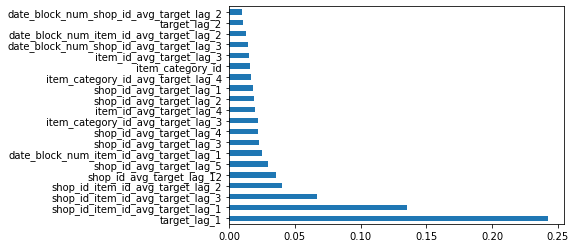

In [18]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [0]:
Y_test = model.predict(X_test).clip(0, 20)
testdata = X_test
testdata['Y_test'] = Y_test

# Add target variable to transactions_test and leave only ID and target
transactions_test.reset_index(inplace = True)
submition = pd.merge(transactions_test, testdata[['shop_id', 'item_id', 'Y_test']], on = ['shop_id', 'item_id'])
submition = submition[['ID', 'Y_test']]
submition.columns = ['ID', 'item_cnt_month']

In [0]:
# Export results
submition.to_csv('V2.csv', index=False)
files.download('V2.csv')

In [0]:
X_train.columns